<a href="https://colab.research.google.com/github/ahekmati/ahekmati.github.io/blob/master/arima_confidence_interval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 15
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from matplotlib import pyplot
import datetime
import pandas_ta as ta
import quandl


In [0]:
pip install pandas_ta quandl


# Getting Crude Price data

In [0]:
mydata = quandl.get("FRED/DCOILWTICO", trim_start="1987-11-20", trim_end="2019-11-25",  authtoken="JvvFdXyoMVKhCixW4_WA")
mydata.to_csv("crudeprice.csv")



# Reading data to a dataframe with dates as index

In [0]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('crudeprice.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse, infer_datetime_format=True)
ts = data['Value']
print (data.head())

            Value
Date             
1987-11-20  18.87
1987-11-23  19.31
1987-11-24  18.73
1987-11-25  18.63
1987-11-27  18.63


# Test for Stationarity

### Plotting Rolling Statistics: 
Plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
### Dickey-Fuller Test: 
This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the time series is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.
Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be accepted or rejected. The result must be interpreted for a given problem to be meaningful.
### Null Hypothesis (H0): 
If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
### Alternate Hypothesis (H1): 
The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure. We interpret this result using the p-value from the test.

A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we accept the null hypothesis (non-stationary).

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [0]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=5).mean()
    rolstd = pd.Series(timeseries).rolling(window=5).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


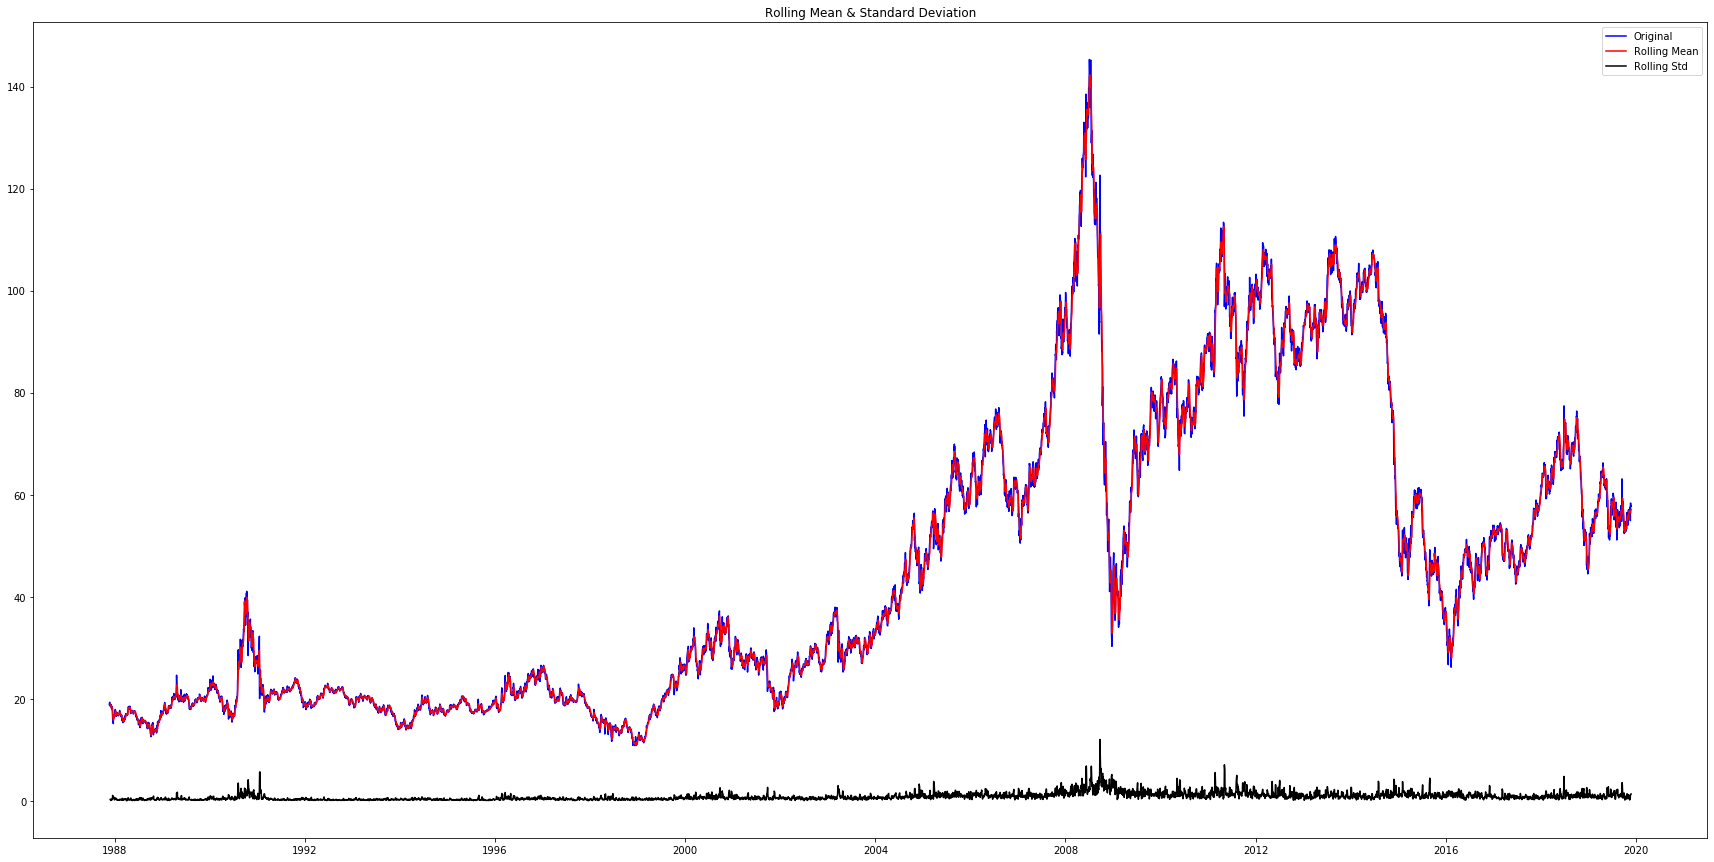

Results of Dickey-Fuller Test:
Test Statistic                   -1.775678
p-value                           0.392602
#Lags Used                        5.000000
Number of Observations Used    8063.000000
Critical Value (1%)              -3.431161
Critical Value (5%)              -2.861899
Critical Value (10%)             -2.566961
dtype: float64


In [0]:
test_stationarity(ts)

We can accept the null-hypothesis to a level. i.e. the series isn't stationary

# Removing Seasonality

### Differencing

Removing peaks in the data.

In [0]:
ts_log = np.log(ts)

In [0]:
ts_log_diff = ts_log - ts_log.shift()

In [0]:
ts_log_diff.dropna(inplace=True)

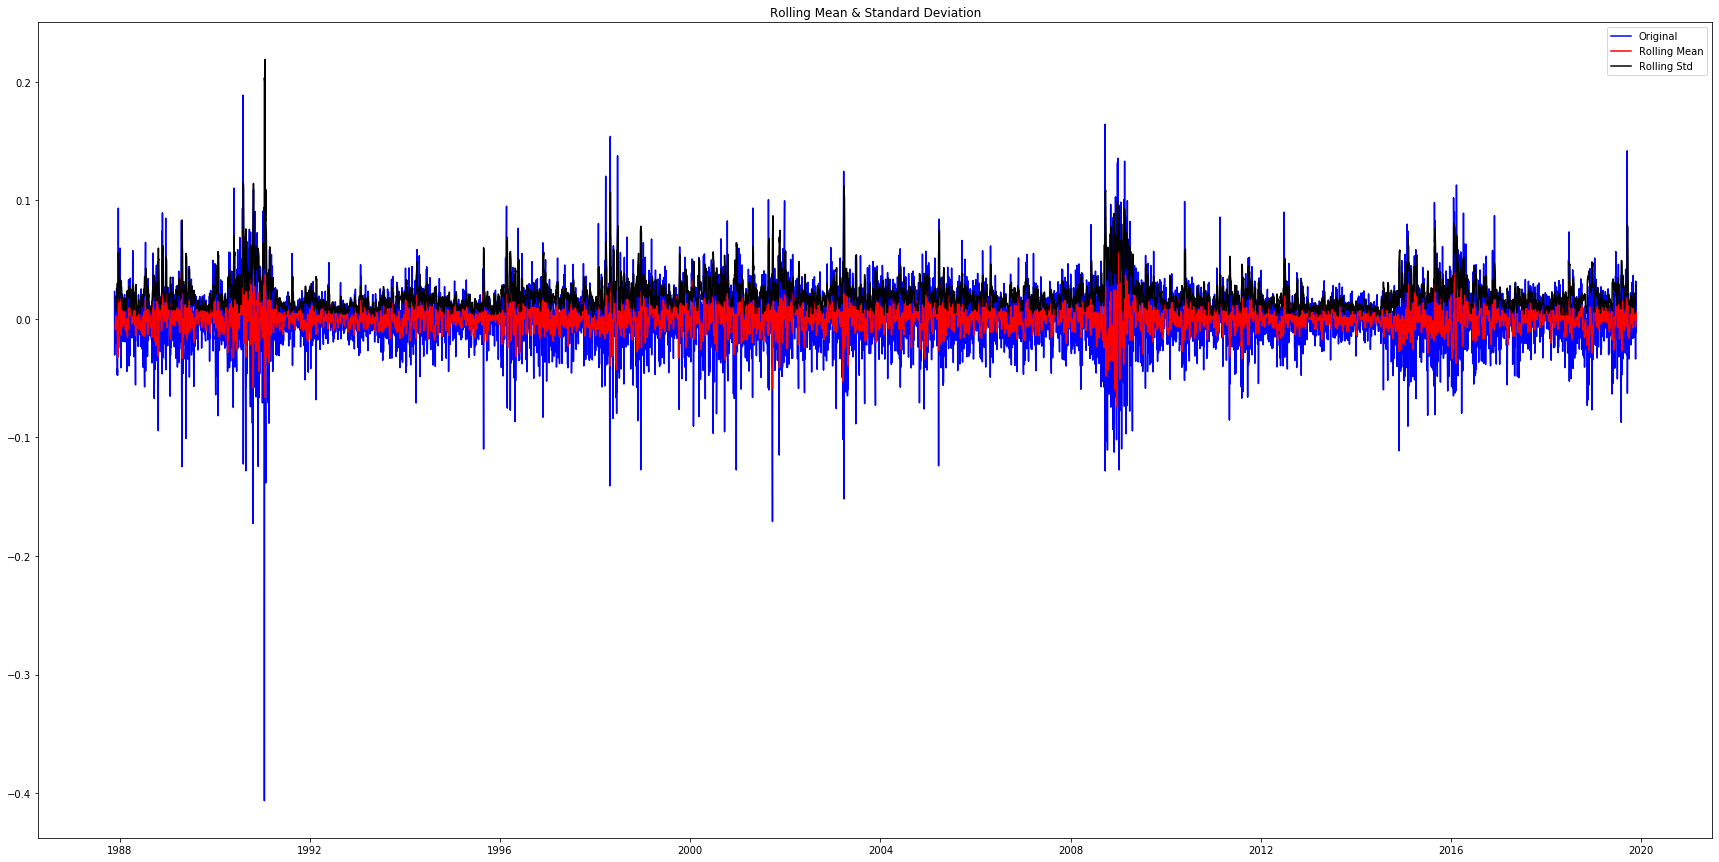

Results of Dickey-Fuller Test:
Test Statistic                  -35.229551
p-value                           0.000000
#Lags Used                        7.000000
Number of Observations Used    8060.000000
Critical Value (1%)              -3.431162
Critical Value (5%)              -2.861899
Critical Value (10%)             -2.566961
dtype: float64


In [0]:
test_stationarity(ts_log_diff)

As Test Statistic is much lower than Critical Value, according to Dickey-Fuller Test we can say that the series is stationary.

# Deciding parameters for ARIMA(p,d,q) Model

The predictors depend on the parameters (p,d,q) of the ARIMA model:

#### Number of AR (Auto-Regressive) terms (p): 
AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

#### Number of MA (Moving Average) terms (q): 
MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
#### Number of Differences (d): 
These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. 

#### Autocorrelation Function (ACF): 
It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

#### Partial Autocorrelation Function (PACF): 
This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [0]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Autocorrelation Function')

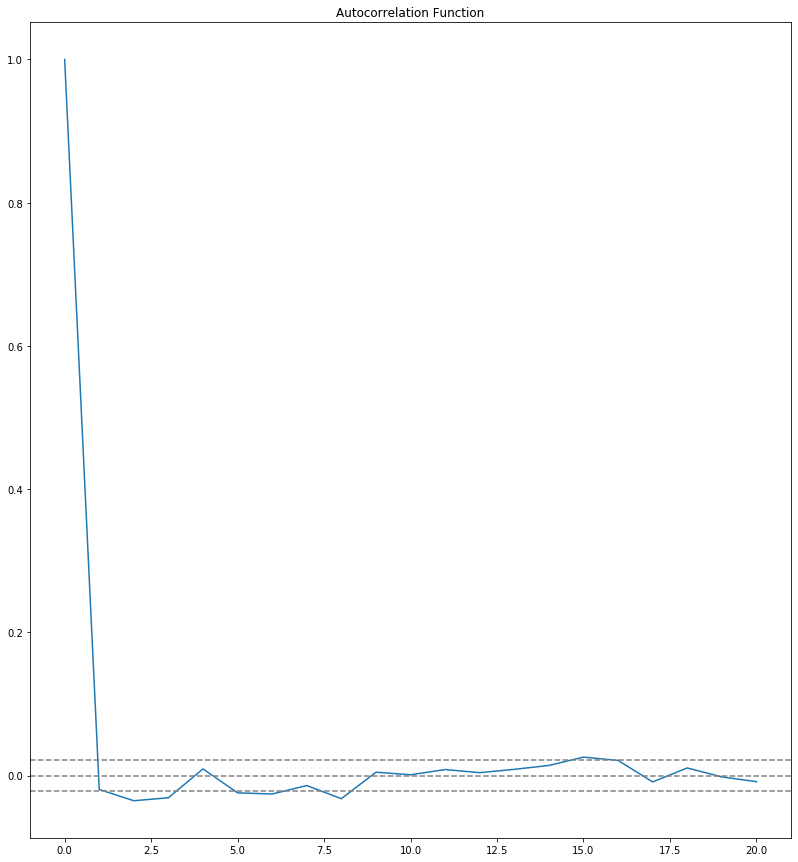

In [0]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

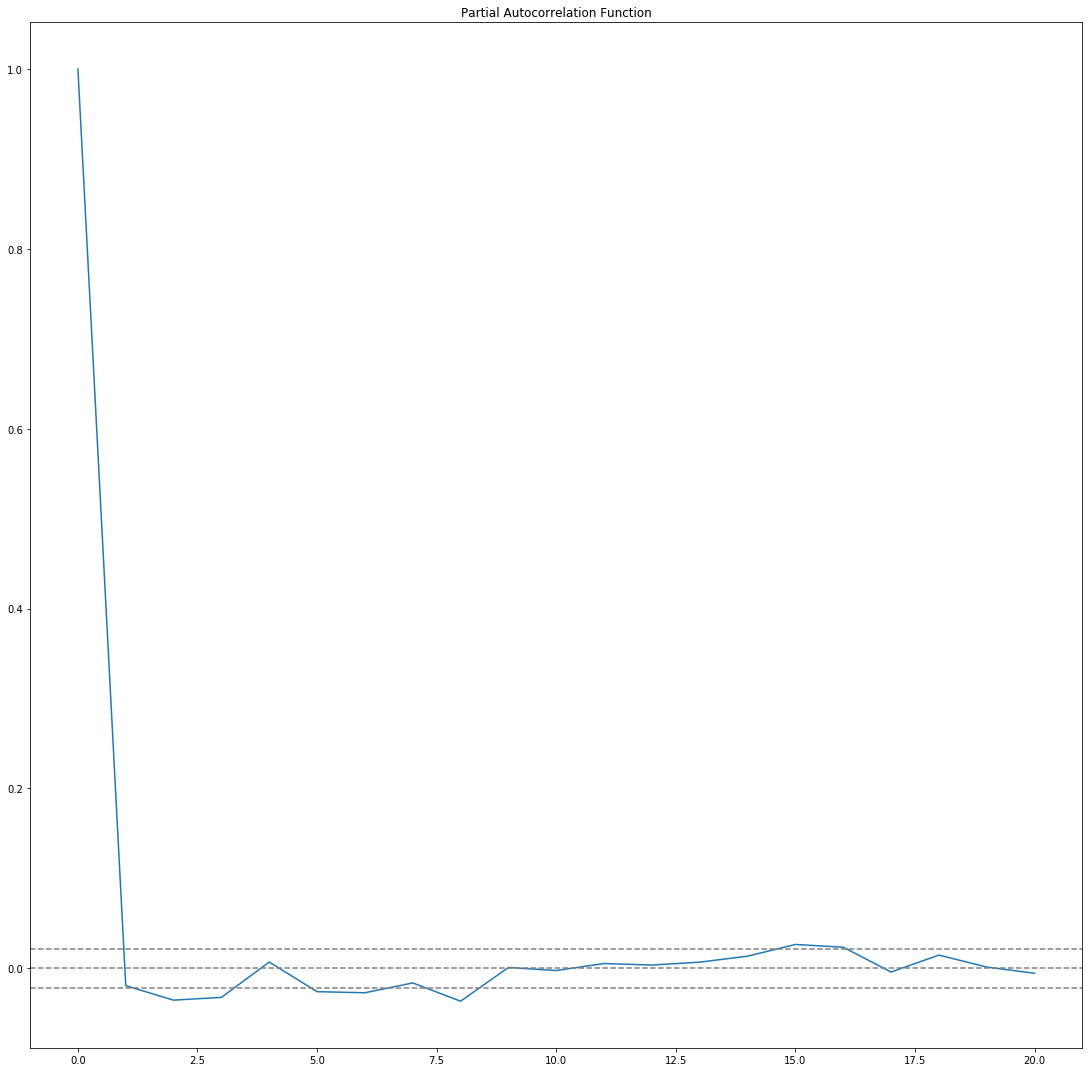

In [0]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### Determining p, q values:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time, being an integer (round off to upper value if not sure). If you notice closely, in this case p=2.

q – The lag value where the ACF chart crosses the upper confidence interval for the first time, being an integer (round off to upper value if not sure). If you notice closely, in this case q=2.

# Predicting the last value in the data

In [0]:
X = ts.values
size = len(X) - 1
train, test = X[0:size], X[size:]
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast()
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Confidence Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

Expected: 57.790
Forecast: 57.686
Standard Error: 1.176
95% Confidence Interval: 55.380 to 59.991


Confidence level determines the band in which we can safely say the predicted and actual values can lie.

In [0]:
X = ts.values
size = len(X) - 1
train, test = X[0:size], X[size:]
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(disp=False)
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
	forecast, stderr, conf = model_fit.forecast(alpha=a)
	print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))

80.0% Confidence Interval: 57.686 between 56.178 and 59.193
90.0% Confidence Interval: 57.686 between 55.751 and 59.621
95.0% Confidence Interval: 57.686 between 55.380 and 59.991
99.0% Confidence Interval: 57.686 between 54.656 and 60.716


# Predictions for the next 5 days

In [0]:
X = ts.values
last_date = data.index[-1] + datetime.timedelta(days=1)
window = 5
model = ARIMA(X, order=(2,1,2))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast(alpha=0.01)
X = np.append(X, forecast)
predictions = {}
print('Expected: %.3f' % X[-1])
print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))
predictions[str(last_date.date())] = (conf[0][0], conf[0][1], forecast[0])

for t in range(window):
    last_date = last_date + datetime.timedelta(days=1)
    model = ARIMA(X, order=(2,1,2))
    model_fit = model.fit(disp=False)
    forecast, stderr, conf = model_fit.forecast(alpha=0.01)
    X = np.append(X, forecast)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))
    predictions[str(last_date.date())] = (conf[0][0], conf[0][1], forecast[0])
    

Expected: 57.888
99.0% Confidence Interval: 57.888 between 54.858 and 60.918
99.0% Confidence Interval: 57.880 between 54.850 and 60.910
99.0% Confidence Interval: 57.844 between 54.814 and 60.873
99.0% Confidence Interval: 57.858 between 54.829 and 60.887
99.0% Confidence Interval: 57.881 between 54.852 and 60.910
99.0% Confidence Interval: 57.880 between 54.851 and 60.909


In [0]:
predictions

{'2019-11-26': (54.85771247492973, 60.9176491373711, 57.887680806150414),
 '2019-11-27': (54.85026942434976, 60.909830567839975, 57.88004999609487),
 '2019-11-28': (54.81409086355903, 60.87327655793068, 57.843683710744855),
 '2019-11-29': (54.82867876472001, 60.88748907974016, 57.85808392223009),
 '2019-11-30': (54.85159091660573, 60.910025922054785, 57.88080841933026),
 '2019-12-01': (54.85055232662254, 60.90861209220197, 57.879582209412256)}